# This notebook creates theoretical microlensing signals.

It can simulate PSPL events and Binary Lens events

# Install muLAn: 
gravitational MICROlensing Analysis Software package from https://github.com/muLAn-project/muLAn

In [1]:
!git clone https://github.com/muLAn-project/muLAn.git
!/usr/local/bin/pip install muLAn/


Cloning into 'muLAn'...
remote: Enumerating objects: 1688, done.
remote: Total 1688 (delta 0), reused 0 (delta 0), pack-reused 1688
Receiving objects: 100% (1688/1688), 3.99 MiB | 23.48 MiB/s, done.
Resolving deltas: 100% (1069/1069), done.
Processing ./muLAn
     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 757kB 14.5MB/s 
     |████████████████████████████████| 112kB 35.0MB/s 
     |████████████████████████████████| 686kB 26.3MB/s 
  ERROR: Failed building wheel for muLAn
  Running setup.py clean for muLAn
  Created wheel for GetDist: filename=GetDist-1.1.3-cp37-none-any.whl size=197835 sha256=c73e0b1392c9136f73c635b269db70045e152ee45b7e7a78350efbdab926c06d
  Stored in directory: /root/.cache/pip/wheels/20/83/bf/457b60706b0e11c579e87c44699b64466d67e6cce1b1765eb7
  Created wheel for PyAstronomy: filename=PyAstronomy-0.15.2-cp37-none-any.whl size=485641 sha256=47f7373bc620d245c56a000b950c85628ba66873e0fc829b4d570c156e529c4c
  Stored in direct

# Script that can generate a gravitational microlensing signal

It has a magnification calculator and a plot function

In [6]:
"""Script that generates a Gravitational Microlensing Signal, within the natural parameters: t0 (Time of peak of the event),
u0 (source-lens impact parameter), tE (Einstein radius crossing time), rho (angular source size normalized by the
angular Einstein radius) , s (Projected separation of the masses normalized by the angular Einstein radius),
q (Mass ratio M_planet/M_host), alpha (Trajectory angle).
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
try:
    from muLAn.models.vbb.vbb import vbbmagU
except ModuleNotFoundError as error:
    raise ModuleNotFoundError(f'{__file__} module requires the muLAn package. Please install separately.') from error
try:
    import muLAn.models.PSPL as PSPL
except ModuleNotFoundError as error:
    raise ModuleNotFoundError(f'{__file__} module requires the muLAn package. Please install separately.') from error


class MagnificationSignal:
    """A class to generate a microlensing magnification signal.
    Using the parameters:
    t0 (Time of peak of the event)
    u0 (source-lens impact parameter)
    tE (Einstein radius crossing time)
    rho (angular source size normalized by the angular Einstein radius)
    s (Projected separation of the masses normalized by the angular Einstein radius)
    q (Mass ratio M_planet/M_host)
    alpha (Trajectory angle)
    > No parallax effect is considered
    """

    def __init__(self):
        self.n_data_points = 2000
        self.timeseries = np.linspace(-30, 30, self.n_data_points)
        self.magnification = None
        self.magnification_signal_curve = None
        self.t0 = None
        self.u0 = None
        self.tE = None
        self.rho = None
        self.s = None
        self.q = None
        self.alpha = None

    def generating_magnification_PSPL(self):
        """
        Creates the magnification signal for a PSPL
        """
        lens_params = dict({'u0': self.u0,
                            'tE': self.tE,
                            't0': self.t0,
                            'piEN': 0.0,
                            'piEE': 0.0
                            })
        Ds = dict({'N': np.zeros(self.n_data_points), 'E': np.zeros(self.n_data_points)})

        # Compute magnification
        self.magnification = PSPL.magnifcalc( self.timeseries, lens_params, Ds=Ds)
        self.magnification_signal_curve = pd.DataFrame({'Time':  self.timeseries, 'Magnification': self.magnification})


    def generating_magnification_binary(self):
        """
        Creates the magnification signal for a Binary Lens
        """
        lens_params = dict({'u0': self.u0,
                            'tE': self.tE,
                            't0': self.t0,
                            'rho': self.rho,
                            's': self.s,
                            'q': self.q,
                            'alpha': self.alpha
                            })

        # Compute magnification
        self.magnification = self.calculating_magnification_from_vbb(self.timeseries, lens_params)
        self.magnification_signal_curve = pd.DataFrame({'Time': self.timeseries, 'Magnification': self.magnification})

    def plot_magnification(self):
        """
        Plot the lightcurve.
        """
        # PLOT
        plt.scatter(self.timeseries, self.magnification, s=2)
        plt.xlabel('Days')
        plt.ylabel('Magnification')
        if self.alpha != None:
            plt.title(f'u0= {self.u0:3.5f}; tE= {self.tE:12.5f}; rho= {self.rho:8.5f};\n s= {self.s:3.5f}; '
                      f'q= {self.q:8.5f}; alpha= {self.alpha:3.5f}')
        else:
            plt.title(f'u0= {self.u0:3.5f}; tE= {self.tE:12.5f}')    
        # plt.title(f'u0= {:3.5f}; tE= {:10.5f}; rho= {:5.5f};\n s= {:3.5f}; '
        #           f'q= {:5.5f}; alpha= {:2.5f}'.format(self.u0,self.tE,self.rho,self.s,self.q,self.alpha))
        plt.show()


    @staticmethod
    def calculating_magnification_from_vbb(timeseries, lens_params):
        """Return the VBB method finite-source uniform magnification.
        Adapted from muLAn: gravitational MICROlensing Analysis Software.
        """
        # Get parameters
        t0 = lens_params['t0']
        u0 = lens_params['u0']
        tE = lens_params['tE']
        rho = lens_params['rho']
        q = lens_params['q']
        alpha = lens_params['alpha']
        s = lens_params['s']

        tau = (timeseries - t0) / tE

        cos_alpha = np.cos(alpha)
        sin_alpha = np.sin(alpha)

        x = tau * cos_alpha - u0 * sin_alpha
        y = tau * sin_alpha + u0 * cos_alpha

        # Conversion secondary body left -> right
        x = -x
        # Compute magnification
        accuracy = 1.e-3  # Absolute mag accuracy (mag+/-accuracy)
        magnification = np.array([vbbmagU(s, q, rho, x[i], y[i], accuracy) for i in range(len(x))])
        return magnification



# How to generate a PSPL example

Decide the number of data points, t0, u0 and tE

--- 0.0032787322998046875 seconds ---


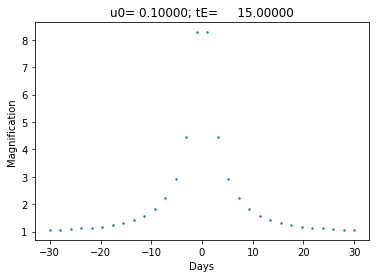

In [7]:
# PSPL example

import time
start_time = time.time()

microlensing_signal_pspl = MagnificationSignal()

microlensing_signal_pspl.n_data_points = 30
microlensing_signal_pspl.timeseries = np.linspace(-30, 30, microlensing_signal_pspl.n_data_points)

microlensing_signal_pspl.t0 = 0.0
microlensing_signal_pspl.u0 = 0.1
microlensing_signal_pspl.tE = 15.0

microlensing_signal_pspl.generating_magnification_PSPL()

print("--- %s seconds ---" % (time.time() - start_time))
microlensing_signal_pspl.plot_magnification()

# How to generate a Binary Lens event example

Decide the number of data points, t0, u0, tE, rho, s, q and alpha

--- 0.27115345001220703 seconds ---


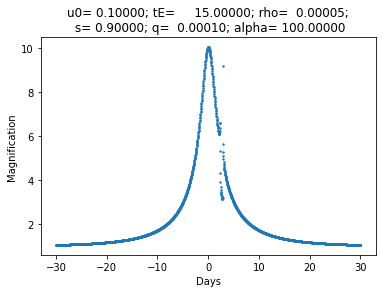

In [8]:
# Binary example

import time
start_time = time.time()

microlensing_signal_binary = MagnificationSignal()

microlensing_signal_binary.n_data_points = 2000
microlensing_signal_binary.timeseries = np.linspace(-30, 30, microlensing_signal_binary.n_data_points)

microlensing_signal_binary.t0 = 0.0
microlensing_signal_binary.u0 = 0.1
microlensing_signal_binary.tE = 15.0
microlensing_signal_binary.rho = 0.000049
microlensing_signal_binary.s = 0.9
microlensing_signal_binary.q = 0.0001
microlensing_signal_binary.alpha = 100

microlensing_signal_binary.generating_magnification_binary()

print("--- %s seconds ---" % (time.time() - start_time))
microlensing_signal_binary.plot_magnification()


# TODO: Introduce errorbars based on the S/N